## Import necessary libraries

In [71]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif

## Data Pre-processing

In [76]:
# --- Load Main Dataset ---
train = pd.read_csv("./home-credit-default-risk/application_train.csv")

print("Initial Train shape:", train.shape)

# Identify all categorical columns
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

# Label encode all categorical columns
label_encoder = LabelEncoder()
for col in cat_cols:
    # Fill missing values in the categorical column with a placeholder (e.g., 'missing')
    train[col].fillna('missing', inplace=True)
    train[col] = label_encoder.fit_transform(train[col])

print("After label encoding, Train shape:", train.shape)

# --- Additional Feature Engineering ---

# Loan payment length
train['PAYMENT_LENGTH'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']

# Difference between actual and expected monthly payment
train['PAYMENT_DIFF'] = train['AMT_CREDIT'] - train['AMT_ANNUITY']

# Ratio between credit usage and credit limit
train['CREDIT_LIMIT_RATIO'] = train['AMT_CREDIT'] / (train['AMT_GOODS_PRICE'] + 1e-6)

# --- Bureau and Bureau Balance ---

bureau = pd.read_csv("./home-credit-default-risk/bureau.csv")
bureau_balance = pd.read_csv("./home-credit-default-risk/bureau_balance.csv")

# Aggregate bureau_balance with time-weighted features
bureau_balance['MONTHS_BALANCE_WEIGHT'] = bureau_balance['MONTHS_BALANCE'].apply(lambda x: np.exp(x / 12))
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min', 'max', 'mean'],
    'STATUS': ['nunique'],
    'MONTHS_BALANCE_WEIGHT': ['sum']
})
bureau_balance_agg.columns = ['BUREAU_BAL_' + '_'.join(col).upper() for col in bureau_balance_agg.columns]

# Merge bureau_balance aggregates with bureau
bureau = bureau.merge(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
del bureau_balance, bureau_balance_agg
gc.collect()

# Aggregate bureau data by SK_ID_CURR
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['mean', 'sum'],
    'BUREAU_BAL_MONTHS_BALANCE_WEIGHT_SUM': ['sum']
})
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]

# Merge bureau aggregates with train
train = train.merge(bureau_agg, how='left', on='SK_ID_CURR')
del bureau, bureau_agg
gc.collect()

# --- Previous Applications ---

prev = pd.read_csv("./home-credit-default-risk/previous_application.csv")

# Create new features
prev['APP_CREDIT_DIFF'] = prev['AMT_CREDIT'] - prev['AMT_APPLICATION']
prev['APP_CREDIT_RATIO'] = prev['AMT_CREDIT'] / (prev['AMT_APPLICATION'] + 1e-6)

# Aggregate previous applications
prev_agg = prev.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': ['mean', 'max'],
    'AMT_CREDIT': ['mean', 'max'],
    'APP_CREDIT_DIFF': ['mean'],
    'APP_CREDIT_RATIO': ['mean'],
    'NAME_CONTRACT_STATUS': ['nunique']
})
prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]

train = train.merge(prev_agg, how='left', on='SK_ID_CURR')
del prev, prev_agg
gc.collect()

# --- POS_CASH_balance ---

pos = pd.read_csv("./home-credit-default-risk/POS_CASH_balance.csv")

# Aggregate POS_CASH_balance
pos_agg = pos.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['max', 'mean'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
})
pos_agg.columns = ['POS_' + '_'.join(col).upper() for col in pos_agg.columns]

train = train.merge(pos_agg, how='left', on='SK_ID_CURR')
del pos, pos_agg
gc.collect()

# --- Installments Payments ---

inst = pd.read_csv("./home-credit-default-risk/installments_payments.csv")

# Aggregate installments payments
inst['PAYMENT_DELAY'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
inst['PAYMENT_RATIO'] = inst['AMT_PAYMENT'] / (inst['AMT_INSTALMENT'] + 1e-6)

inst_agg = inst.groupby('SK_ID_CURR').agg({
    'AMT_INSTALMENT': ['mean', 'sum'],
    'AMT_PAYMENT': ['mean', 'sum'],
    'PAYMENT_DELAY': ['mean', 'max'],
    'PAYMENT_RATIO': ['mean']
})
inst_agg.columns = ['INST_' + '_'.join(col).upper() for col in inst_agg.columns]

train = train.merge(inst_agg, how='left', on='SK_ID_CURR')
del inst, inst_agg
gc.collect()

# Print the final shape of the train dataset
print(f"Final Train shape: {train.shape}")


Initial Train shape: (307511, 122)


/var/folders/my/5pbqkp817313j1bx7jlmbynr0000gn/T/ipykernel_68960/2021764616.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna('missing', inplace=True)
/var/folders/my/5pbqkp817313j1bx7jlmbynr0000gn/T/ipykernel_68960/2021764616.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

After label encoding, Train shape: (307511, 122)
Final Train shape: (307511, 153)


In [ ]:
# --- Fill Missing Values with Median ---
train.fillna(train.median(), inplace=True)


# --- Drop Duplicate Rows ---
duplicates = train.duplicated().sum()
print(f"Number of Duplicate Rows: {duplicates}")
train.drop_duplicates(inplace=True)

# --- Define Features and Target ---
X = train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = train['TARGET']

# --- Use a Subset of Data for Feature Selection ---
sample_frac = 0.6  # Use 60% of the data for feature selection
X_sample = X.sample(frac=sample_frac, random_state=42)
y_sample = y.loc[X_sample.index]
print(f"Feature selection will use {len(X_sample)} samples out of {len(X)}")

# --- Compute Correlation Matrix on Sampled Data ---
corr_matrix = X_sample.corr().abs()

# Identify pairs of features with correlation > 0.9
high_corr_pairs = [(col, corr_matrix.columns[j]) for i, col in enumerate(corr_matrix.columns) 
                   for j in range(i + 1, len(corr_matrix.columns)) if corr_matrix.iloc[i, j] > 0.90]

# --- Compute Mutual Information Scores on Sampled Data ---
print("Calculating mutual information scores...")
mi_scores = mutual_info_classif(X_sample, y_sample, n_jobs=-1)
mi_scores_dict = dict(zip(X_sample.columns, mi_scores))

# --- Drop One Feature from Each Correlated Pair Based on Mutual Information ---
features_to_drop = set()

for col1, col2 in high_corr_pairs:
    if mi_scores_dict[col1] < mi_scores_dict[col2]:
        features_to_drop.add(col1)
    else:
        features_to_drop.add(col2)

# Drop the selected features
X = X.drop(columns=list(features_to_drop))
print(f"After removing highly correlated features, Train shape: {X.shape}")

# --- Remove Features with Low Predictive Power ---
low_mi_threshold = 0.001
low_mi_features = [col for col, score in mi_scores_dict.items() if score < low_mi_threshold]

X = X.drop(columns=low_mi_features, errors='ignore')
print(f"After removing low predictive power features, Train shape: {X.shape}")

# --- Split into Training and Validation Sets ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Before SMOTE, Training Data Shape: {X_train.shape}")
print("Before SMOTE, Class Distribution in Training Data:")
print(y_train.value_counts())

# --- Feature Scaling AFTER Splitting ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# --- Apply SMOTE to the TRAINING Data ONLY ---
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE, Training Data Shape: {X_train_smote.shape}")
print("After SMOTE, Class Distribution in Training Data:")
print(y_train_smote.value_counts())

# Convert scaled arrays back to DataFrames
X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

Number of Duplicate Rows: 0
Feature selection will use 184507 samples out of 307511
Calculating mutual information scores...
After removing highly correlated features, Train shape: (307511, 110)
After removing low predictive power features, Train shape: (307511, 76)
Before SMOTE, Training Data Shape: (246008, 76)
Before SMOTE, Class Distribution in Training Data:
TARGET
0    226132
1     19876
Name: count, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


After SMOTE, Training Data Shape: (452264, 76)
After SMOTE, Class Distribution in Training Data:
TARGET
0    226132
1    226132
Name: count, dtype: int64


## Model Development & Deployment


Training and evaluating HistGradientBoosting...


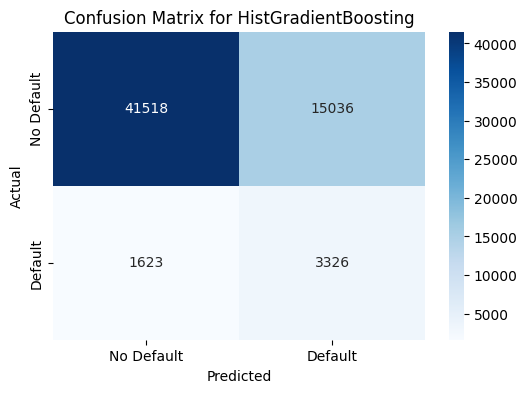


Training and evaluating RandomForest...


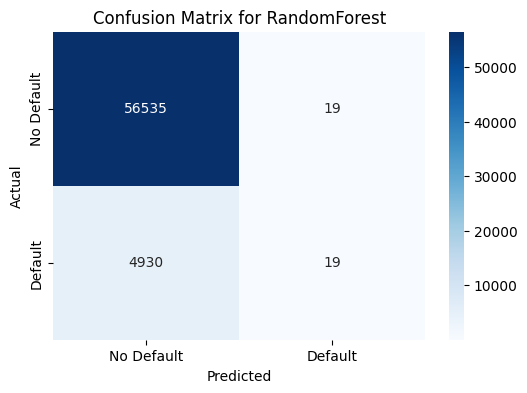


Training and evaluating LogisticRegression...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


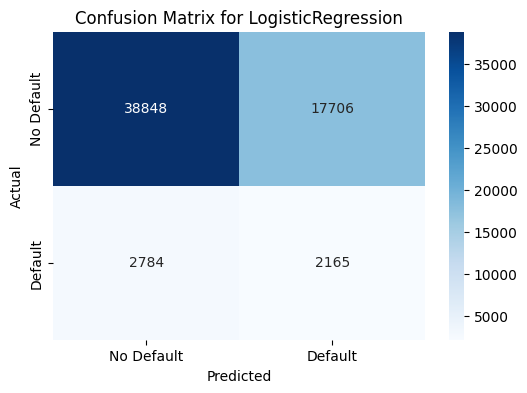


Model Performance Metrics Summary:


,Model,AUC,Accuracy,Precision,Recall,F1 Score
0,HistGradientBoosting,0.773059,0.729135,0.181135,0.672055,0.285359
1,RandomForest,0.735036,0.919532,0.500000,0.003839,0.007620
2,LogisticRegression,0.589391,0.666846,0.108953,0.437462,0.174456


In [78]:
# Testing three different models
models = {
    'HistGradientBoosting': HistGradientBoostingClassifier(
        learning_rate=0.01, max_iter=1000, max_leaf_nodes=63, random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(
        n_estimators=100, random_state=42, n_jobs=-1, verbose=0, class_weight='balanced'),
    'LogisticRegression': LogisticRegression(
        max_iter=1000, random_state=42, n_jobs=-1, class_weight='balanced', verbose=0)
}

# Decision Threshold (will optimize later)
threshold = 0.5 
 
# Initialize a list to store metrics for each model
metrics_summary = []

# Loop through each model
for model_name, model in models.items():
    print(f"\nTraining and evaluating {model_name}...")
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Apply threshold to predicted probabilities
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    auc = roc_auc_score(y_val, y_pred_proba)
    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Store metrics in the summary list
    metrics_summary.append({
        'Model': model_name,
        'AUC': auc,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Create a DataFrame for the metrics summary and display it
metrics_df = pd.DataFrame(metrics_summary)
print("\nModel Performance Metrics Summary:")
display(metrics_df)


In [ ]:
# --- Define the Hyperparameter Grid ---
param_grid = {
    'learning_rate': [0.01, 0.05,0.1],
    'max_iter': [500, 1000, 1500],
    'max_leaf_nodes': [31, 63, 127],
}

# --- Grid Search with Cross-Validation ---
grid_search = GridSearchCV(
    HistGradientBoostingClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on the training data
print("\nPerforming Grid Search...")
grid_search.fit(X_train, y_train)

# Best estimator and parameters
best_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")

threshold = 0.5

# --- Model Evaluation with Best Parameters ---
print("\nEvaluating Best Model...")
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Apply threshold to predicted probabilities
y_pred = (y_pred_proba >= threshold).astype(int)

# Calculate metrics
auc = roc_auc_score(y_val, y_pred_proba)
acc = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Print metrics
print(f"\nBest Model Metrics:")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Training HistGradientBoosting model...
Optimal Threshold for Maximum F1 Score: 0.6662
Maximum F1 Score: 0.3204


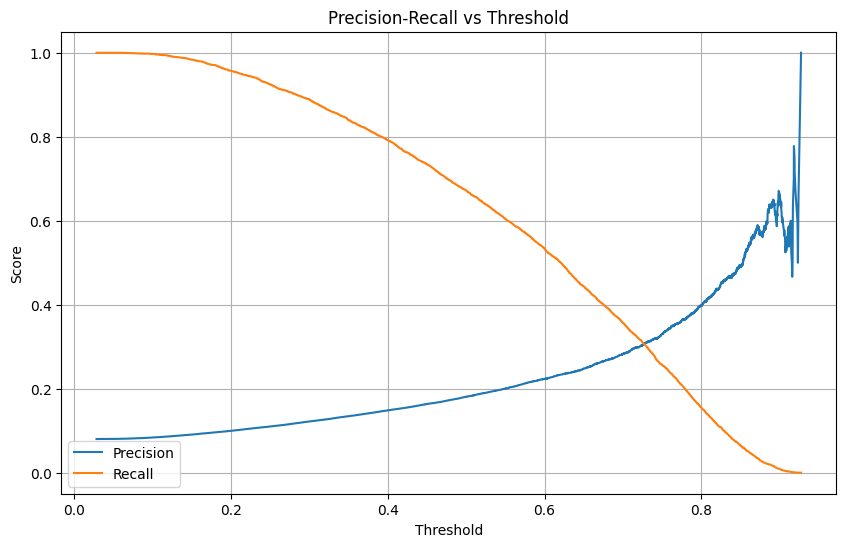

In [79]:
# Train HistGradientBoosting model
hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.01, max_iter=1000, max_leaf_nodes=63, random_state=42, class_weight='balanced'
)
print("\nTraining HistGradientBoosting model...")
hgb_model.fit(X_train, y_train)
y_pred_proba = hgb_model.predict_proba(X_val)[:, 1]

# Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Find the optimal threshold (maximum F1 score)
optimal_index = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_index]
optimal_f1 = f1_scores[optimal_index]

print(f"Optimal Threshold for Maximum F1 Score: {optimal_threshold:.4f}")
print(f"Maximum F1 Score: {optimal_f1:.4f}")

# Plot Precision, Recall, and F1 Score vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()



Re-training HistGradientBoosting model...

Performance with Threshold 0.6662:
F1 Score: 0.3204
AUC Score: 0.7731


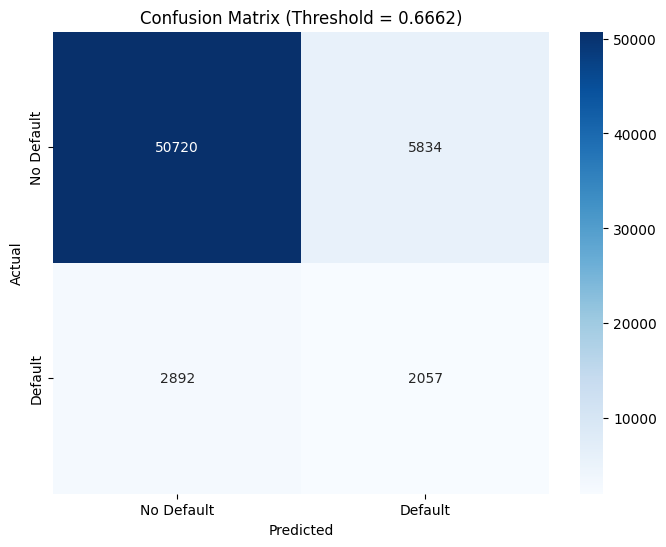

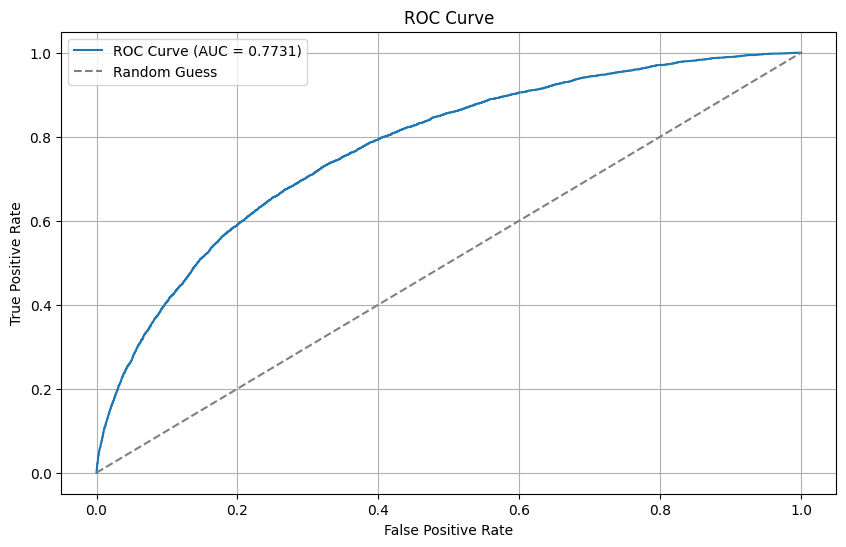

In [ ]:
# Re-train HistGradientBoosting model with the new threshold
hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.01, max_iter=1000, max_leaf_nodes=63, random_state=42, class_weight='balanced'
)
print("\nRe-training HistGradientBoosting model...")
hgb_model.fit(X_train, y_train)
y_pred_proba = hgb_model.predict_proba(X_val)[:, 1]

# Apply the new threshold
threshold = 0.6662
y_pred = (y_pred_proba >= threshold).astype(int)

# Print performance metrics
f1 = f1_score(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_proba)
print(f"\nPerformance with Threshold {threshold}:")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default', 'Default'], 
            yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

# Plot AUC (ROC) Curve
fpr, tpr, roc_thresholds = roc_curve(y_val, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


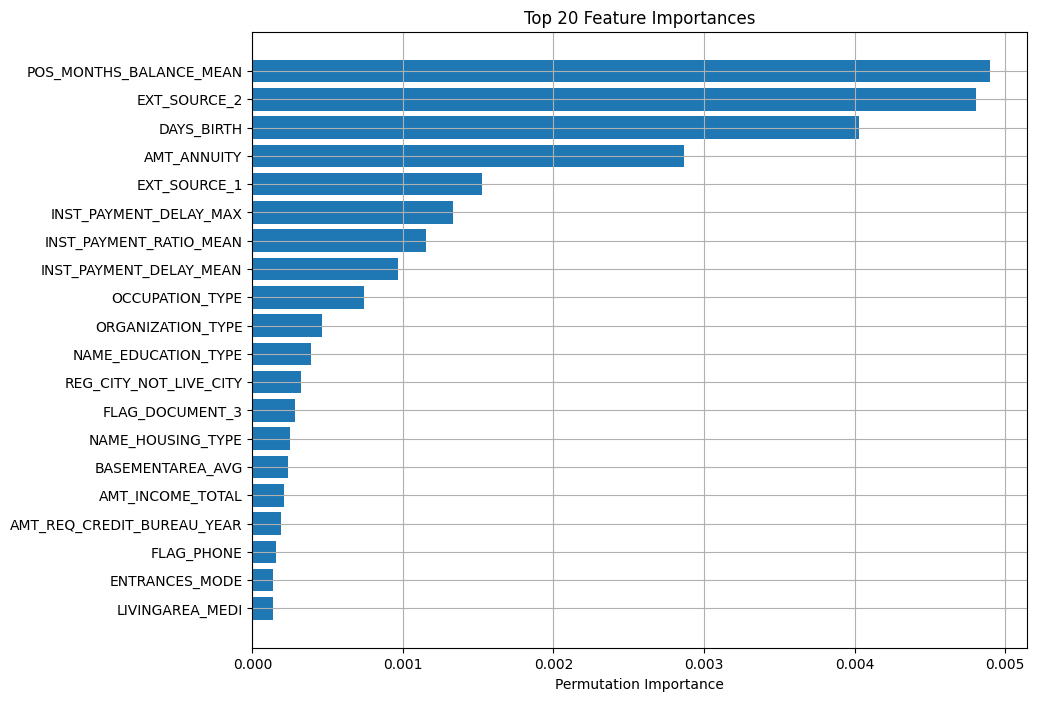

In [81]:
# Compute permutation feature importance
result = permutation_importance(hgb_model, X_val, y_val, n_repeats=2, random_state=42, n_jobs=-1)

# Get feature names and their importance values
features = X_train.columns
importances = result.importances_mean

# Sort the feature importances and get the top 20
sorted_idx = np.argsort(importances)[-20:]

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Top 20 Feature Importances')
plt.grid(True)
plt.show()
